# Hydrological Event Analysis & Flood Prediction
Author: ChatGPT (generated on 2025-08-06 21:12)

This notebook loads hourly discharge & rainfall data, reproduces event graphs like the examples you shared, and trains a **classical ML model** to predict high‐flow ("flood") hours.

Feel free to tweak any cell — especially the `THRESHOLD_CMS` variable that defines what counts as a flood.

In [8]:
from pathlib import Path
import pandas as pd

# ── CONFIG ─────────────────────────────────────────────────────────────
PROJECT_ROOT = Path.cwd().parent               # ← wherever the notebook lives
DATA_ROOT    = PROJECT_ROOT / 'data' / 'raw'

CSV_PATHS = {
    'D08A071': DATA_ROOT / 'station_D08A071' / 'D08A071.csv',
    'D08A084': DATA_ROOT / 'station_D08A084' / 'D08A084.csv',
    'D08A115': DATA_ROOT / 'station_D08A115' / 'D08A115.csv',
}
THRESHOLD_CMS = 20
# ────────────────────────────────────────────────────────────────────────

# quick sanity check
for code, p in CSV_PATHS.items():
    print(f"{code}: {p.exists()} → {p}")
    assert p.exists(), f"Missing file: {p}"

def load_csv(file_path: Path) -> pd.DataFrame:
    df = pd.read_csv(file_path)
    df['datetime'] = pd.to_datetime(df['saatlik'])
    df = df.set_index('datetime').sort_index()
    return df[['yagis_toplam', 'qdeger']]

data_frames = {code: load_csv(path) for code, path in CSV_PATHS.items()}
print(f"Loaded {len(data_frames)} stations →", list(data_frames))

D08A071: True → /Users/tree/Projects/hydro-flood-poc/data/raw/station_D08A071/D08A071.csv
D08A084: True → /Users/tree/Projects/hydro-flood-poc/data/raw/station_D08A084/D08A084.csv
D08A115: True → /Users/tree/Projects/hydro-flood-poc/data/raw/station_D08A115/D08A115.csv
Loaded 3 stations → ['D08A071', 'D08A084', 'D08A115']


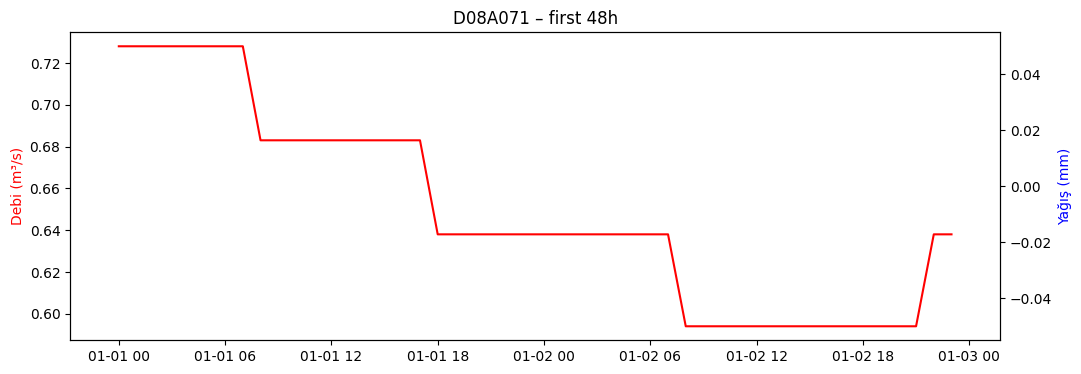

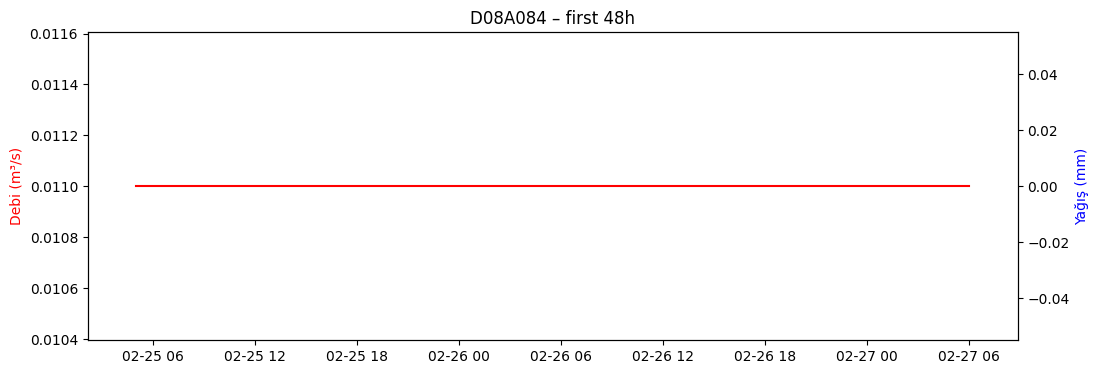

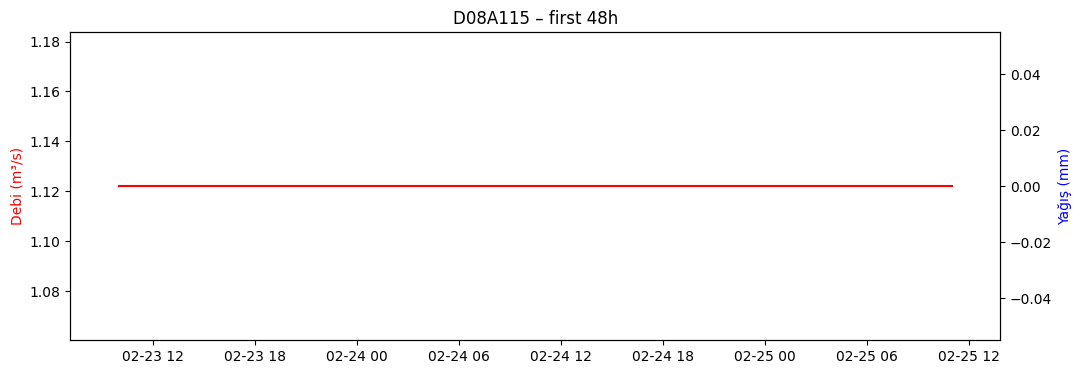

In [9]:
# --- Visualisation helper ---
def plot_event(df, title='Event'):
    fig, ax1 = plt.subplots(figsize=(12,4))
    ax2 = ax1.twinx()
    ax1.plot(df.index, df['qdeger'], color='red', label='Debi (m³/s)')
    ax2.bar(df.index, df['yagis_toplam'], color='royalblue', label='Rain (mm)', width=0.03)
    ax1.set_ylabel('Debi (m³/s)', color='red')
    ax2.set_ylabel('Yağış (mm)', color='blue')
    ax1.set_title(title)
    plt.show()

# quick preview first 48h of each file
for name, df in data_frames.items():
    plot_event(df.iloc[:48], title=f'{name} – first 48h')


In [10]:
# --- Concatenate all data ---
full_df = pd.concat(data_frames, names=['station', 'datetime'])
full_df = full_df.reset_index().set_index('datetime')
full_df.sort_index(inplace=True)

# label flood events
full_df['flood'] = (full_df['qdeger'] > THRESHOLD_CMS).astype(int)
full_df.head()


,station,yagis_toplam,qdeger,flood
datetime,,,,
2014-01-01 00:00:00,D08A071,0.0,0.728,0
2014-01-01 01:00:00,D08A071,0.0,0.728,0
2014-01-01 02:00:00,D08A071,0.0,0.728,0
2014-01-01 03:00:00,D08A071,0.0,0.728,0
2014-01-01 04:00:00,D08A071,0.0,0.728,0


## Feature engineering
We’ll keep it simple for now:
* **Current rainfall (mm)**
* **Rolling 3‑hour sum of rainfall**
* **Rolling 6‑hour sum of rainfall**
* **Rolling 12‑hour sum of rainfall**

In [11]:
fe = full_df.copy()
for win in [3,6,12]:
    fe[f'rain_sum_{win}h'] = fe['yagis_toplam'].rolling(win, min_periods=1).sum()

features = ['yagis_toplam', 'rain_sum_3h', 'rain_sum_6h', 'rain_sum_12h']
X = fe[features].fillna(0)
y = fe['flood']
print(X.shape, y.mean())


(116929, 4) 0.00630297017848438


### Train/test split – time‑based
We’ll dedicate the **last 20 %** of rows as the test set to avoid leakage.

In [12]:
split_idx = int(len(X)*0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print('Train:', X_train.shape, 'Test:', X_test.shape)


Train: (93543, 4) Test: (23386, 4)


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

clf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.98      0.99     23379
           1       0.00      0.14      0.01         7

    accuracy                           0.98     23386
   macro avg       0.50      0.56      0.50     23386
weighted avg       1.00      0.98      0.99     23386

Confusion matrix:
 [[23011   368]
 [    6     1]]


## Next steps
* Tune the `THRESHOLD_CMS` or derive it statistically (e.g., 95th percentile).
* Experiment with additional features (lagged discharge, rainfall intensity change).
* Try sequence models (LSTM) for improved temporal learning.
* Add cross‑validation using blocked time series CV.